### Octave Band Filter function - definition

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Public methods
__all__ = ['octavefilter', 'getansifrequencies', 'normalizedfreq']


def octavefilter(input_directory, fraction=1, order=6, limits=None, show=0, sigbands =0):
    """
    Filter a signal with octave or fractional octave filter bank. This
    method uses a Butterworth filter with Second-Order Sections
    coefficients. To obtain the correct coefficients, a subsampling is
    applied to the signal in each filtered band.

    :param x: Signal
    :param fs: Sample rate
    :param fraction: Bandwidth 'b'. Examples: 1/3-octave b=3, 1-octave b=1,
    2/3-octave b = 3/2. [Optional] Default: 1.
    :param order: Order of Butterworth filter. [Optional] Default: 6.
    :param limits: Minimum and maximum limit frequencies. [Optional] Default
    [12,20000]
    :param show: Boolean for plot o not the filter response.
    :param sigbands: Boolean to also return the signal in the time domain
    divided into bands. A list with as many arrays as there are frequency bands.
    :returns: Sound Pressure Level and Frequency array
    """

    if limits is None:
        limits = [12, 20000]

    fs, x = wavfile.read(input_directory)

    # mono transformation
    if len(x.shape) == 2:
        x = np.mean(x, axis=1)

    # Downsampling
    if fs != 22000:
        downsample_factor = np.round(fs / 22000)
        x = x[::int(downsample_factor)]
        fs = 22000

   
    # List type for signal var
    x = _typesignal(x)
    
    # Generate frequency array
    freq, freq_d, freq_u = _genfreqs(limits, fraction, fs)

    # Calculate the downsampling factor (array of integers with size [freq])
    factor = _downsamplingfactor(freq_u, fs)

    # Get SOS filter coefficients (3D - matrix with size: [freq,order,6])
    sos = _buttersosfilter(freq, freq_d, freq_u, fs, order, factor, show)

    if sigbands:
        # Create array with SPL for each frequency band
        spl = np.zeros([len(freq)])
        xb = []
        for idx in range(len(freq)):
            sd = signal.resample(x, round(len(x) / factor[idx]))
            y = signal.sosfilt(sos[idx], sd)
            spl[idx] = 20 * np.log10(np.std(y) / 2e-5)
            xb.append(signal.resample_poly(y,factor[idx],1))
        return spl.tolist(), freq, xb
    else:
        # Create array with SPL for each frequency band
        spl = np.zeros([len(freq)])
        for idx in range(len(freq)):
            sd = signal.resample(x, round(len(x) / factor[idx]))
            y = signal.sosfilt(sos[idx], sd)
            spl[idx] = 20 * np.log10(np.std(y) / 2e-5)
        return spl.tolist(), freq


def _typesignal(x):
    if type(x) is list:
        return x
    elif type(x) is np.ndarray:
        return x.tolist()
    elif type(x) is tuple:
        return list(x)


def _buttersosfilter(freq, freq_d, freq_u, fs, order, factor, show=0):
    # Initialize coefficients matrix
    sos = [[[]] for i in range(len(freq))]
    # Generate coefficients for each frequency band
    for idx, (lower, upper) in enumerate(zip(freq_d, freq_u)):
        # Downsampling to improve filter coefficients
        fsd = fs / factor[idx]  # New sampling rate
        # Butterworth Filter with SOS coefficients
        sos[idx] = signal.butter(
            N=order,
            Wn=np.array([lower, upper]) / (fsd / 2),
            btype='bandpass',
            analog=False,
            output='sos')

    if show:
        _showfilter(sos, freq, freq_u, freq_d, fs, factor)

    return sos


def _showfilter(sos, freq, freq_u, freq_d, fs, factor):
    wn = 8192
    w = np.zeros([wn, len(freq)])
    h = np.zeros([wn, len(freq)], dtype=np.complex_)

    for idx in range(len(freq)):
        fsd = fs / factor[idx]  # New sampling rate
        w[:, idx], h[:, idx] = signal.sosfreqz(
            sos[idx],
            worN=wn,
            whole=False,
            fs=fsd)

    fig, ax = plt.subplots()
    ax.semilogx(w, 20 * np.log10(abs(h) + np.finfo(float).eps), 'b')
    ax.grid(which='major')
    ax.grid(which='minor', linestyle=':')
    ax.set_xlabel(r'Frequency [Hz]')
    ax.set_ylabel('Amplitude [dB]')
    ax.set_title('Second-Order Sections - Butterworth Filter')
    plt.xlim(freq_d[0] * 0.8, freq_u[-1] * 1.2)
    plt.ylim(-4, 1)
    ax.set_xticks([16, 31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])
    ax.set_xticklabels(['16', '31.5', '63', '125', '250', '500',
                        '1k', '2k', '4k', '8k', '16k'])
    plt.show()


def _genfreqs(limits, fraction, fs):
    # Generate frequencies
    freq, freq_d, freq_u = getansifrequencies(fraction, limits)

    # Remove outer frequency to prevent filter error (fs/2 < freq)
    freq, freq_d, freq_u = _deleteouters(freq, freq_d, freq_u, fs)

    return freq, freq_d, freq_u


def normalizedfreq(fraction):
    """
    Normalized frequencies for one-octave and third-octave band. [IEC
    61260-1-2014]

    :param fraction: Octave type, for one octave fraction=1,
    for third-octave fraction=3
    :type fraction: int
    :returns: frequencies array
    :rtype: list
    """
    predefined = {1: _oneoctave(),
                  3: _thirdoctave(),
                  }
    return predefined[fraction]


def _thirdoctave():
    # IEC 61260 - 1 - 2014 (added 12.5, 16, 20 Hz)
    return [12.5, 16, 20, 25, 31.5, 40, 50, 63, 80, 100, 125, 160, 200, 250,
            315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 2500, 3150, 4000,
            5000, 6300, 8000, 10000, 12500, 16000, 20000]


def _oneoctave():
    # IEC 61260 - 1 - 2014 (added 16 Hz)
    return [16, 31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]


def _deleteouters(freq, freq_d, freq_u, fs):
    idx = np.asarray(np.where(np.array(freq_u) > fs / 2))
    if any(idx[0]):
        _printwarn('Low sampling rate, frequencies above fs/2 will be removed')
        freq = np.delete(freq, idx).tolist()
        freq_d = np.delete(freq_d, idx).tolist()
        freq_u = np.delete(freq_u, idx).tolist()
    return freq, freq_d, freq_u


def getansifrequencies(fraction, limits=None):
    """ ANSI s1.11-2004 && IEC 61260-1-2014
    Array of frequencies and its edges according to the ANSI and IEC standard.

    :param fraction: Bandwidth 'b'. Examples: 1/3-octave b=3, 1-octave b=1,
    2/3-octave b = 3/2
    :param limits: It is a list with the minimum and maximum frequency that
    the array should have. Example: [12,20000]
    :returns: Frequency array, lower edge array and upper edge array
    :rtype: list, list, list
    """

    if limits is None:
        limits = [12, 20000]

    # Octave ratio g (ANSI s1.11, 3.2, pg. 2)
    g = 10 ** (3 / 10)  # Or g = 2
    # Reference frequency (ANSI s1.11, 3.4, pg. 2)
    fr = 1000

    # Get starting index 'x' and first center frequency
    x = _initindex(limits[0], fr, g, fraction)
    freq = _ratio(g, x, fraction) * fr

    # Get each frequency until reach maximum frequency
    freq_x = 0
    while freq_x * _bandedge(g, fraction) < limits[1]:
        # Increase index
        x = x + 1
        # New frequency
        freq_x = _ratio(g, x, fraction) * fr
        # Store new frequency
        freq = np.append(freq, freq_x)

    # Get band-edges
    freq_d = freq / _bandedge(g, fraction)
    freq_u = freq * _bandedge(g, fraction)

    return freq.tolist(), freq_d.tolist(), freq_u.tolist()


def _initindex(f, fr, g, b):
    if b % 2:  # ODD ('x' solve from ANSI s1.11, eq. 3)
        return np.round(
                (b * np.log(f / fr) + 30 * np.log(g)) / np.log(g)
                )
    else:  # EVEN ('x' solve from ANSI s1.11, eq. 4)
        return np.round(
                (2 * b * np.log(f / fr) + 59 * np.log(g)) / (2 * np.log(g))
                )


def _ratio(g, x, b):
    if b % 2:  # ODD (ANSI s1.11, eq. 3)
        return g ** ((x - 30) / b)
    else:  # EVEN (ANSI s1.11, eq. 4)
        return g ** ((2 * x - 59) / (2 * b))


def _bandedge(g, b):
    # Band-edge ratio (ANSI s1.11, 3.7, pg. 3)
    return g ** (1 / (2 * b))


def _printwarn(msg):
    print('*********\n' + msg + '\n*********')


def _downsamplingfactor(freq, fs):
    guard = 0.10
    factor = (np.floor((fs / (2+guard)) / np.array(freq))).astype('int')
    for idx in range(len(factor)):
        # Factor between 1<factor<50
        factor[idx] = max(min(factor[idx], 50), 1)
    return factor

### Test on Data


*********
Low sampling rate, frequencies above fs/2 will be removed
*********


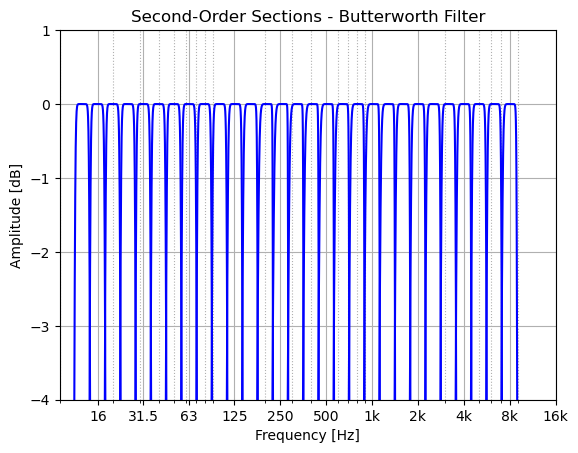

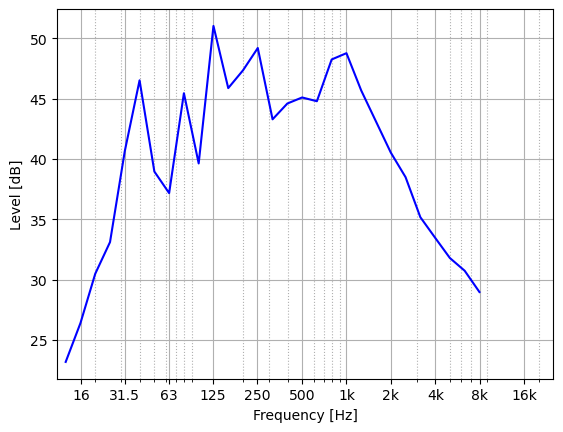

In [9]:
from scipy.io import wavfile
pathi = "/Users/Anton/Documents/KIT/Seminare/RTN/Audio rtn-samples/IDMT_Traffic/audio/2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_41346_M_D_CR_SE_CH34.wav"
#pathi = "/Users/Anton/Documents/KIT/Seminare/RTN/Audio rtn-samples/IDMT_Traffic/audio/2019-11-12-09-00_Schleusinger-Allee_70Kmh_2076056_M_W_CR_ME_CH12.wav"

#sample_rate, data = wavfile.read(pathi)
spl, freq = octavefilter(pathi, fraction=3, order=6, limits=[12, 20000], show=1)

# Show octave spectrum
fig, ax = plt.subplots()
ax.semilogx(freq, spl, 'b')
ax.grid(which='major')
ax.grid(which='minor', linestyle=':')
ax.set_xlabel(r'Frequency [Hz]')
ax.set_ylabel('Level [dB]')
plt.xlim(11, 25000)
ax.set_xticks([16, 31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])
ax.set_xticklabels(['16', '31.5', '63', '125', '250', '500', '1k', '2k', '4k', '8k', '16k'])
plt.show()

### Apply to total Dataset and safe frequency & dB values in new Excel file



In [8]:
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy.fftpack import dct


def process_dataset_octaveband (input_directory, output_file, n=10, m=3):
    """
    perform octave filter of (fraction n ) on all .wav files in a repository, safe a (number of m) highest dB values 
    with according frequency band in an excel file.
    Args:
        input_directory (str): input repository
        output_file (str): path to output file (Excel).
        n (int): fraction of octave band filters per octave
        m (int): number of dB peaks that should be safed  from each file
    """
    results = []
    
    for file_name in os.listdir(input_directory):
        if file_name.endswith(".wav"):
            file_path = os.path.join(input_directory, file_name)
            try:
                #calculate m-peak values from octave bands
                spl, freq = octavefilter(file_path, fraction=n, order=6, limits=[12, 20000], show=0)
                pairs = list(zip(spl, freq))
                pairs_sorted = sorted(pairs, key=lambda x: x[0], reverse=True) # sort by size of spl
                top_pairs = pairs_sorted[:m]

                # safe m-peak values in result []
                result_entry = {
                      'file': os.path.basename(file_path).replace('.wav', '')  
                }
    
                # Save top m peaks in result
                for i, (spl_peak, freq_peak) in enumerate(top_pairs):
                    result_entry[f'max_octband_dB_{i+1}'] = spl_peak
                    result_entry[f'max_octband_freq_{i+1}'] = freq_peak
                
                # Save all octave band SPL values
                for i, spl_value in enumerate(spl):
                    result_entry[f'octband_dB_{i+1}'] = spl_value

                # Calculate and save average SPL value
                result_entry['octband_dB_mean'] = sum(spl) / len(spl)
      
                results.append(result_entry)
    
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
    
    # safe as new excel
    df = pd.DataFrame(results)
    df.to_excel(output_file, index=False)
    
    print(f"Octave-Band-Filter results with {m} peak(s) and fraction {n} saved in: "
      f"{file_path}")


# apply octave band filter with n = 1 and m= 3 on total dataset
input_directory = "/Users/Anton/Documents/KIT/Seminare/RTN/Audio rtn-samples/IDMT_Traffic/audio"  # input directory
output_file = "/Users/Anton/Documents/KIT/Seminare/RTN/rtn-seminar-status/RoadTrafficNoise/RTN-antonia/OctaveBandOutput_n3_m3.xlsx"
process_dataset_octaveband(input_directory, output_file, n=3, m=3)


*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be remo

C:\Users\Anton\AppData\Local\Temp\ipykernel_27068\2719495389.py:78: RuntimeWarning: divide by zero encountered in log10
  spl[idx] = 20 * np.log10(np.std(y) / 2e-5)


*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be remo

KeyboardInterrupt: 

### Test apllication

In [7]:
# Beispiel: Berechnung für ein Verzeichnis
input_directory = "/Users/Anton/Documents/KIT/Seminare/RTN/Audio rtn-samples/IDMT_Traffic/audio/Preprocessed_Audiofiles_Test"  # input directory
output_file = "/Users/Anton/Documents/KIT/Seminare/RTN/rtn-seminar-status/RoadTrafficNoise/RTN-antonia/TestOctaveBandOutputn3m1.xlsx"
process_dataset_octaveband(input_directory, output_file, n=3, m=1)

*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be remo

### Merche OctaveBandOutput.xlsl with original dataset 

In [ ]:
import pandas as pd

def merge_octaveband_datasets (directory_originaldata, directory_octavedata, outputname):
    # Load datasets
    df_dataset = pd.read_excel(directory_originaldata)
    octave_dataset = pd.read_excel(directory_octavedata)

    # Merge datasets on 'file' column (left join to retain all rows in df_dataset)
    df_merged = pd.merge(df_dataset, octave_dataset, on="file", how="left")

    # Save the merged dataset
    df_merged.to_excel(outputname, index=False)
    print(f"Merged dataset saved as {outputname}")


directory_originaldata = "df_dataset.xlsx"
directory_octavedata ="/Users/Anton/Documents/KIT/Seminare/RTN/rtn-seminar-status/RoadTrafficNoise/RTN-antonia/OctaveBandOutput_n1_m3.xlsx"
outputname = "df_dataset_OCTBND_n1_m3_merged.xlsx"

merge_octaveband_datasets (directory_originaldata, directory_octavedata, outputname)

Merged dataset saved as df_dataset_OCTBND_n1_m3_merged.xlsx


### Add mean on spl peaks 

In [ ]:
# not finished!!!
import pandas as pd

# Define the input and output file paths
file = "df_dataset_OCTBND_n1_m3_merged.xlsx"

# Load the Excel file
df = pd.read_excel(file)

# Identify MFCC columns (assumes they are named like 'mfcc_1', 'mfcc_2', etc.)
spl_octave_columns = [col for col in df.columns if col.startswith('mfcc_')]

# Calculate the mean of MFCC columns for each row
df['mfcc_mean'] = df[mfcc_columns].mean(axis=1)

# Save the updated dataset back to the same Excel file
df.to_excel(file_path, index=False)
print(f"Updated dataset with 'mfcc_mean' saved to: {file_path}")